# Cas Kaggle
Nom: Christian Ferré Delgado <br/><br/>
NIU: 1565129

## 1. Introducció:

El mètode de diagnòstic recomenat pel coronavirus és una tècnica bassada en qPCR, el problema d'aquesta és que requereix molt de temps, és costós i depèn de la mostra amb una proporció relativament alta de falsos negatius. Per tant, l'objectiu d'aquest estudi va ser desenvolupar un mètode àmpliament disponible, barat i ràpid per diagnosticar la malaltia COVID-19 basat en l'espectroscòpia Raman. Aquesta base de dades recull tots els resultats d'aquests mètode i el diagnòstic final. Per tant, l'objectiu principal és crear un model i veure com de bo és aquest analitzant la variable diagnostic, la qual té dos possibles valors: 'Healthy' per als pacients no infectats i 'SARS-CoV-2' pels pacients infectats.

Base de dades: https://www.kaggle.com/sfran96/raman-spectroscopy-for-detecting-covid19?select=tube_spectra.csv

### Dependències:

In [500]:
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

import seaborn as sns

## 2. Anàlisi de la base de dades:

Carreguem el dataset:

In [501]:
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

dataset = load_dataset('covid_and_healthy_spectra.csv')
print(dataset.head())

   400       402       405       407       410       412       415       417  \
0  0.0 -0.015237 -0.030607 -0.038309 -0.039078 -0.035809 -0.031176 -0.030395   
1  0.0 -0.012098 -0.028164 -0.035189 -0.036138 -0.031050 -0.026015 -0.027539   
2  0.0 -0.013000 -0.029058 -0.035021 -0.034994 -0.033025 -0.028413 -0.028470   
3  0.0 -0.015728 -0.034346 -0.045140 -0.047671 -0.044334 -0.040807 -0.040474   
4  0.0 -0.020355 -0.045839 -0.060556 -0.065805 -0.064988 -0.062097 -0.061955   

        420       422  ...      2101      2103      2104      2105      2107  \
0 -0.033311 -0.031603  ... -0.000553  0.000118  0.000566  0.001245  0.000846   
1 -0.028084 -0.027075  ... -0.000998  0.000278 -0.000123  0.000384  0.001010   
2 -0.029737 -0.029198  ... -0.001554  0.000050  0.000866  0.000877  0.000871   
3 -0.041417 -0.040699  ... -0.001541 -0.000198  0.000202  0.001023  0.000625   
4 -0.064759 -0.066886  ... -0.000088  0.000891  0.000942  0.001294  0.001878   

       2108      2109      2111  2112 

Comprovem en el tipus d'atributs:

In [502]:
dataset.dtypes.to_frame("Type").T

,400,402,405,407,410,412,415,417,420,422,...,2101,2103,2104,2105,2107,2108,2109,2111,2112,diagnostic
Type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,object


Podem observar que tots són del tipus float64 menys l'atribut objectiu que és del tipus object. Per tant, cambiarem els valors de la nostre variable objectiu('diagnostic'), és a dir, cambiarem 'Healthy' per '1' i 'SARS-CoV-2' per '0' per cambiar la variable de tipus object a int.

In [503]:
dataset['diagnostic'].replace(['Healthy', 'SARS-CoV-2'],[1,0],inplace=True)
print(dataset['diagnostic'])

0      1
1      1
2      1
3      1
4      1
      ..
304    0
305    0
306    0
307    0
308    0
Name: diagnostic, Length: 309, dtype: int64


Comprovem si ha valors nuls:

In [504]:
print("Is there NaN values?",  dataset.isnull().values.any()) 

Is there NaN values? False


Com podem observar en el resultat anterior, com no hi han valors nuls, no hem de tractar-los.

També ens interesarà reduir el nombre de columnes, ja que tenim un nombre excessiu de variables, tal i com podem veure en la següent execució:

In [505]:
print("Número total de variables/columnes: ", dataset.shape[1])

Número total de variables/columnes:  901


A més, per veure si la base de dades és desbalancejada comptarem el nombre de 1 i 0 de possibles sortides:

In [506]:
item_count = dataset["diagnostic"].value_counts()
print(item_count)

0    159
1    150
Name: diagnostic, dtype: int64


Per sort, tenim la base de dades balancejada ja que un 50% de les dades tenen com a valor de l'atribut 'diagnostic' 1 i la resta 0. Per consegüent, ens estalviem haver de tractar-ho.

### 2.1 Correlació de dades:

Ara veurem la correlació entre les variables que tinguin més i menys correlació amb 'diagnostic':

In [507]:
#Variables amb més correlació
corr = dataset.corr()['diagnostic'].sort_values(ascending=False)
print(corr[:30])

diagnostic    1.000000
2085          0.714829
2086          0.694169
2080          0.683209
2084          0.678898
2088          0.669515
2078          0.668636
2081          0.651142
1995          0.634188
1757          0.631542
1761          0.630211
2048          0.629639
1759          0.625877
2046          0.623862
1780          0.619791
1996          0.611250
1756          0.611148
2053          0.608785
1998          0.606318
2049          0.605902
2089          0.605471
2021          0.605216
1779          0.602798
2050          0.596201
2077          0.596000
2019          0.588424
2018          0.585161
2017          0.583929
2045          0.581895
2052          0.581544
Name: diagnostic, dtype: float64


In [508]:
#Variables amb menys correlació:
corr_inv = dataset.corr()['diagnostic'].sort_values(ascending=True)
print(corr[:30])

diagnostic    1.000000
2085          0.714829
2086          0.694169
2080          0.683209
2084          0.678898
2088          0.669515
2078          0.668636
2081          0.651142
1995          0.634188
1757          0.631542
1761          0.630211
2048          0.629639
1759          0.625877
2046          0.623862
1780          0.619791
1996          0.611250
1756          0.611148
2053          0.608785
1998          0.606318
2049          0.605902
2089          0.605471
2021          0.605216
1779          0.602798
2050          0.596201
2077          0.596000
2019          0.588424
2018          0.585161
2017          0.583929
2045          0.581895
2052          0.581544
Name: diagnostic, dtype: float64


Com que hi han moltes variables, eliminarem les variables amb una correlació inferior a 0.6:

In [509]:
#eliminem columnes amb baixa correlació
corr = dataset.corr()['diagnostic']
dataset_r = dataset
for i in dataset:
    if corr[i] < 0.6:
        dataset_r = dataset_r.drop([i],axis = 1)
        
print(dataset_r.shape)

(309, 32)


Reduïm 869 variables

### 2.2 Normalització de dades:

In [510]:
dataset_r.describe()

,400,904,1080,1251,1359,1410,1517,1647,1746,1756,...,2053,2078,2080,2081,2084,2085,2086,2088,2089,diagnostic
count,309.0,309.0,309.0,309.0,309.0,309.0,309.0,309.0,309.0,309.000000,...,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.009855,...,-0.019182,-0.007409,-0.007734,-0.008013,-0.008650,-0.009461,-0.010260,-0.010716,-0.011097,0.485437
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001922,...,0.001886,0.001395,0.001462,0.001580,0.001612,0.001643,0.001650,0.001475,0.001379,0.500599
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.013881,...,-0.025196,-0.014216,-0.015635,-0.015002,-0.016397,-0.016355,-0.017492,-0.016863,-0.018024,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011426,...,-0.020708,-0.008471,-0.008748,-0.009102,-0.009822,-0.010678,-0.011643,-0.011843,-0.011927,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.009882,...,-0.018885,-0.007186,-0.007497,-0.007799,-0.008251,-0.009119,-0.009912,-0.010414,-0.010875,0.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.008329,...,-0.017882,-0.006316,-0.006622,-0.006866,-0.007493,-0.008167,-0.008990,-0.009615,-0.010049,1.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004256,...,-0.014741,-0.004140,-0.004840,-0.000360,-0.002475,-0.006034,-0.006631,-0.007668,-0.008264,1.000000


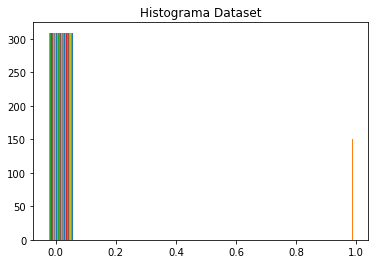

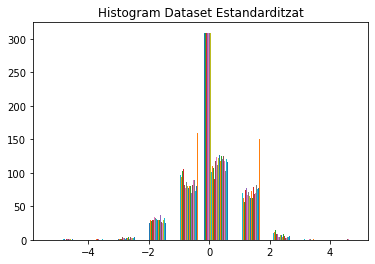

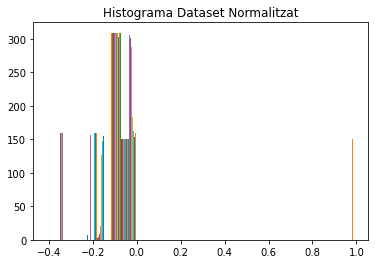

In [511]:
#Sense fer res
plt.title('Histograma Dataset')
plt.hist(dataset_r)
plt.show()

#Estandardització 
scaler = StandardScaler()
scaler.fit(dataset_r)
standard = scaler.transform(dataset_r)
plt.title('Histogram Dataset Estandarditzat')
plt.hist(standard)
plt.show()

#Normalització
normal = Normalizer().transform(dataset_r)
plt.title('Histograma Dataset Normalitzat')
plt.hist(normal)
plt.show()

Com podem veure en els dos histogrames, és molt millor estandarditzar les dades, ja que ens genera una distribuició gaussiana.

## 3.0 Selecció de models


En aquest apartat entrenarem i testejarem diferents models per posteriorment comparar els resultats. Primer de tot dividim les dades en train_data i test_data.


In [512]:
data = dataset.values
x = data[:, :899]
y = dataset['diagnostic'].values
x_t, x_v, y_t, y_v = train_test_split(x, y, train_size=0.8)

#Estandarditzem
scaler = StandardScaler()
scaler.fit(x_t)
x_t = scaler.transform(x_t)
x_v = scaler.transform(x_v)

### 3.1 Decision Tree:

Primer de tot, començarem amb un decision tree:

In [513]:
clf = DecisionTreeClassifier()
clf.fit(x_t,y_t)
pred = clf.predict(x_v)
print("ROC AUC score classification: ", roc_auc_score(y_v, pred))

ROC AUC score classification:  0.835978835978836


### 3.2 Random Forest:

In [514]:
crf = RandomForestClassifier(random_state = 0)
crf = crf.fit(x_t,y_t)
pred = crf.predict(x_v)
print("ROC AUC score classification: ", roc_auc_score(y_v, pred))

ROC AUC score classification:  0.9158730158730158


### 3.3 Regresor logísitc:

In [515]:
clr = LogisticRegression(C=10, fit_intercept=True, penalty='l2', tol=0.001, max_iter=1000000)
clr = clr.fit(x_t,y_t)
pred = clr.predict(x_v)
print("ROC AUC score classification: ", roc_auc_score(y_v, pred))

ROC AUC score classification:  0.9714285714285714


## 4.0 Resultats

Degut a que la base de dades és balancejada compararem els models segons la mètrica AUC aplicant Cross Validation a cada model, a més, utilitzarem RepeatedKFold per a que siguin més fiables les execucions.

In [520]:
def crossValidation(model, k, n):
    rkf = RepeatedKFold(n_splits=k, n_repeats=n)
    scores = cross_val_score(model, x_t, y_t, cv=rkf, scoring="roc_auc")
    print("%0.2f AUC with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [521]:
#Decision Tree
print("Decision Tree:")
crossValidation(clf,10,3)
print("==============================")
#Random Forest
print("Random Forest:")
crossValidation(crf,10,3)
print("==============================")
#Regresor logístic
print("Regresor logístic:")
crossValidation(clr,10,3)

Decision Tree:
0.88 AUC with a standard deviation of 0.07
Random Forest:
0.96 AUC with a standard deviation of 0.04
Regresor logístic:
0.99 AUC with a standard deviation of 0.01


Com podem veure en els resultats de l'execució anterior, el millor model és el Regresor Logísitc amb un AUC de 0.99 i una desviació estàndard de 0.01, és a dir una classificació casi perfecte.